# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

#### Ход исследования

- исследование предоставленных данных
- проведем предварительную обработку (проверку аномалий, пропусков и пр.)
- создадим и обучим несколько моделей
- проведем анализ и сравнение результатов работы моделей



#### Итоговый вывод:

В данной работе нами предложена модель предсказания цены автомобиля для приложения сервиса по продаже автомобилей с пробегом «Не бит, не крашен».

На этапе обработки данных избавились от столбцов с датой скачивания анкеты, даты последней активности пользователя и даты регистрации как мало информативные. А также столбец с месяцем регистрации авто, так как из-за обилия нулевых значений адекватно заменить не получилось бы. \
Нами были удалены явные дубликаты, а также дубликаты в марках автомобилей, типе топлива.
Для каждой марки при совпадении названии модели создана своя замена.
В столбце с годом выпуска автомобиля и мощностью были удалены выбросы.
Было обнаружено что датасет выбран из автомобилей Германии и на основании этого заменен на область в которой продавался автомобиль.
Выяснили что большая часть автомобилей представлена с пробегом 150000км, и из-за ограничения это значение является максимальным, но наверняка есть автомобили пробег которых значительно больше.
Проверили признаки на мультиколлениарность.
Добавили новый признак с разницей между пробегом автомобиля и медианным пробегом для такой же марки того же года. Что дало небольшой прирост качества.

Для обучения модели нами выбраны две модели на основе градиентного бустинга CatBoostRegressor и LGBMRegressor. И одна попроще Ridge regression.

По скорости обучения и предсказания лидирует Ridge. Обе модели градиентного бустинга проигрывают в скорости зато выигрывают в качестве предсказания. 

По совокупности результатов качества  и скорости предсказания, рекомендуется для разработки приложения использовать модель на основе CatBoostRegressor с рассчитанными ниже параметрами.

## Описание данных

**Признаки**

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя

**Целевой признак**

    Price — цена (евро)

## Исследование и подготовка данных

Загрузим необходимые библиотеки

In [24]:
import re
import os

from catboost import CatBoostRegressor

from IPython.display import display

from lightgbm import LGBMRegressor as lgbmr

import matplotlib.pyplot as plt
import numpy as np
#plt.style.use('dark_background') # Темная тема для matplotlib
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.utils import shuffle # Миксер
from sklearn.utils.validation import check_is_fitted

Загрузим данные

In [25]:
pth1 = 'autos.csv' # Для VSC
pth2 = '/datasets/autos.csv'
if os.path.exists(pth1):
    df = pd.read_csv(pth1)
    print("Датасет успешно загружен c GoogleDisc")
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
    print("Датасет успешно загружен c Яндекс.Практикум")
else:
    print("Проверьте правильность пути к датасету")

Датасет успешно загружен c GoogleDisc


In [26]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Переименуем столбцы

In [27]:
new_columns_name=[]
for column in df.columns:
    new_columns_name.append(re.sub(r'(?<!^)(?=[A-Z])', '_', column).lower())
df.columns = new_columns_name

In [28]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [29]:
df.tail()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Проверим на пропуски

In [31]:
display(pd.DataFrame(round((df.isna().mean()*100),2), columns=['NaNs, %']).style.format(
    '{:.2f}').background_gradient('coolwarm'))

,"NaNs, %"
date_crawled,0.00
price,0.00
vehicle_type,10.58
registration_year,0.00
gearbox,5.60
power,0.00
model,5.56
kilometer,0.00
registration_month,0.00
fuel_type,9.28


Довольно значительное количество пропусков во всех столбцах где они были обнаружены, поэтому просто удалить не получится попробуем обработать их далее

Проверим на дубликаты

In [32]:
df.duplicated().sum()

4

In [33]:
df = df.drop_duplicates()

Проверим столбцы `last_seen`, `date_created`, `date_crawled`

In [34]:
df['date_created'] = pd.to_datetime(df['date_created'])
df['last_seen'] = pd.to_datetime(df['last_seen'])
df['date_crawled'] = pd.to_datetime(df['date_crawled'])

In [35]:
df[['last_seen', 'date_created', 'date_crawled']].apply([min, max], axis=0)

,last_seen,date_created,date_crawled
min,2016-03-05 14:15:08,2014-03-10,2016-03-05 14:06:22
max,2016-04-07 14:58:51,2016-04-07,2016-04-07 14:36:58


In [36]:
(df['date_crawled'] - df['last_seen']).mean()

Timedelta('-9 days +13:07:02.754275959')

Дата скачивания анкеты была проставлена раньше чем дата последнего визита пользователя
Похоже что эти столбцы не принесут польезной информации как и столбец с датой создания анкеты `date_created`, удалим их, заодно избавимся от столбца с нулевыми значениями, `number_of_pictures`

In [37]:
df = df.drop(['last_seen', 
              'date_created',
              'number_of_pictures'], axis=1)

In [38]:
df.describe()

,price,registration_year,power,kilometer,registration_month,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,99998.000000


В цене есть "0", оправданием может служить плохое техническое состояние или необходимость уплаты налога при утилизации. Не исключаем также вероятность автоматического заполнения пропусков "0", как и для столбца `power`, а также месяца регистрации `registration_month`

Проверим какие марки встречаются у нас, с количеством моделей

In [39]:
df.groupby('brand')['model'].nunique().sort_values(ascending=False)

brand
volkswagen        22
mercedes_benz     18
opel              16
audi              16
ford              14
land_rover        10
bmw               10
seat              10
renault           10
fiat              10
nissan             9
volvo              9
toyota             8
mazda              8
citroen            7
kia                7
lancia             7
daihatsu           7
skoda              7
mitsubishi         7
alfa_romeo         6
chrysler           6
peugeot            6
chevrolet          5
subaru             5
rover              5
hyundai            5
dacia              5
daewoo             5
honda              5
mini               4
smart              4
suzuki             4
lada               4
jeep               4
porsche            4
jaguar             3
saab               3
trabant            2
sonstige_autos     0
Name: model, dtype: int64

sonstige_autos - автомобили бывшие в эксплуатации, скорее всего используется вместо неизвестных значений, также заменим rover = land_rover

In [40]:
df.loc[df['brand'] == 'land_rover', 'brand'] = 'rover'

Проверим есть ли совпадающие названия у разных производителей, если есть добавим к ней название производителя

In [41]:
for model in df['model'].unique():
    if df[df['model'] == model]['brand'].nunique() > 1:
        print( model, df[df['model'] == model]['brand'].unique())
        df['model'].where(~(df['model'] == model), other=df.brand + ' ' + model, inplace=True)

grand ['jeep' 'suzuki' 'chrysler']
other ['volkswagen' 'mercedes_benz' 'hyundai' 'seat' 'honda' 'mitsubishi' 'opel'
 'fiat' 'suzuki' 'lancia' 'mazda' 'nissan' 'toyota' 'chevrolet' 'renault'
 'peugeot' 'kia' 'citroen' 'bmw' 'ford' 'chrysler' 'audi' 'jaguar' 'skoda'
 'porsche' 'rover' 'smart' 'saab' 'alfa_romeo' 'mini' 'volvo' 'trabant'
 'lada' 'daewoo' 'jeep' 'daihatsu' 'subaru' 'dacia']
3_reihe ['mazda' 'peugeot']
5_reihe ['mazda' 'peugeot']
matiz ['chevrolet' 'daewoo']
1_reihe ['mazda' 'peugeot']


Заменим пропуски в названиях моделей на название бренда добавив unknown_model

In [42]:
df['model'].where(~(df['model'].isna()), other=df['brand'] +' unknown_model', inplace=True)

В названиях моделей встречается reihe - с немецкого переводится как "линия", значит можно предположить что датасет немецкий.
Система присвоения индексов совпадает с принятой почтой Германии
Заменим индексы на названия регионов

In [43]:
df['zone'] = df['postal_code'] // 10000
df = df.drop('postal_code', axis=1)

index_dict = {0: "Dresden_Leipzig", 
              1: "Berlin", 
              2: "Hamburg_Bremen", 
              3: "Hannover", 
              4: "Duesseldorf_Dortmund", 
              5: "Koeln", 
              6: "Frankfurt", 
              7: "Stuttgart", 
              8: "Muenchen", 
              9: "Nuernberg_Bayer"}

df.zone = df.zone.replace(index_dict)

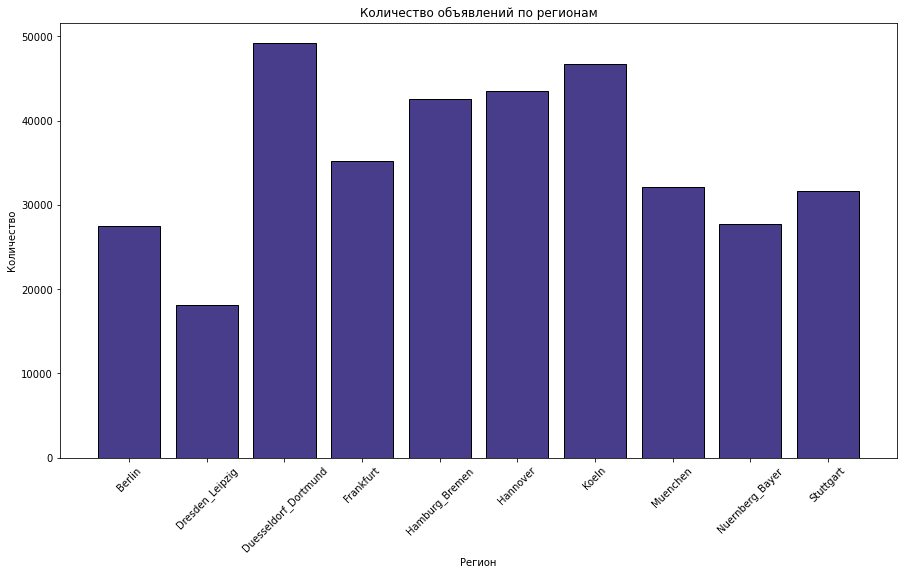

In [44]:
zone_model_pivot = df.pivot_table(index='zone', values='model', aggfunc='count').reset_index()
plt.figure(figsize=(15,8))
plt.bar(zone_model_pivot['zone'], zone_model_pivot['model'], edgecolor = "black", color='darkslateblue')
plt.title('Количество объявлений по регионам')
plt.xlabel('Регион')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

Посмотрим на пробег автомобилей в датасете

In [45]:
df.kilometer.unique()

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000], dtype=int64)

Похоже, что пробег пользователь выбирает из представленных доступных значений

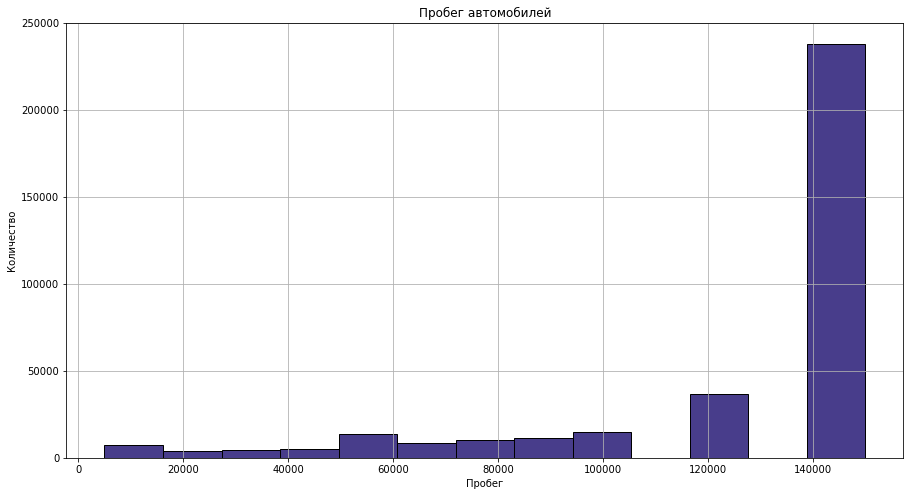

In [46]:
df['kilometer'].hist(bins=df['kilometer'].nunique(), figsize=(15, 8), edgecolor = "black", color='darkslateblue')
plt.title('Пробег автомобилей')
plt.xlabel('Пробег')
plt.ylabel('Количество');

Значительная часть автомобилей представлена с пробегом 150 000км. И так как это максимальное доступное число скорее всего в реальности пробег у автомобилей значительно выше. 

Проверим столбец с годом регистрации `registration_year`

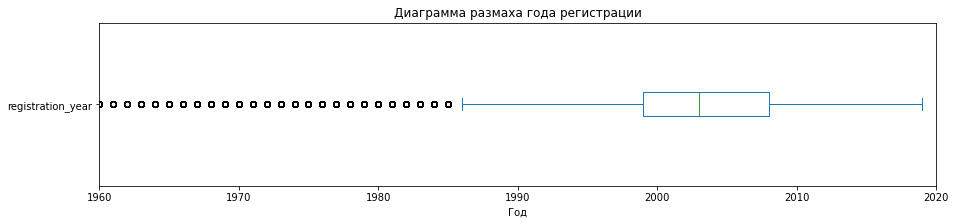

In [47]:
df['registration_year'].plot(kind='box', figsize=(15,3), vert=False, xlim=(1960, 2020))
plt.title("Диаграмма размаха года регистрации")
plt.xlabel("Год");

In [25]:
df.query('1950 > registration_year')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,zone
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,Hamburg_Bremen
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,opel unknown_model,5000,0,NaN,opel,NaN,Duesseldorf_Dortmund
1928,2016-03-25 15:58:21,7000,suv,1945,manual,48,volkswagen other,150000,2,petrol,volkswagen,no,Koeln
2273,2016-03-15 21:44:32,1800,convertible,1925,NaN,0,sonstige_autos unknown_model,5000,1,NaN,sonstige_autos,no,Stuttgart
6629,2016-04-02 13:47:16,0,small,1910,NaN,0,sonstige_autos unknown_model,5000,1,other,sonstige_autos,NaN,Nuernberg_Bayer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
346046,2016-03-26 16:45:28,18900,suv,1943,manual,60,volkswagen other,150000,3,petrol,volkswagen,no,Koeln
348830,2016-03-22 00:38:15,1,NaN,1000,NaN,1000,sonstige_autos unknown_model,150000,0,NaN,sonstige_autos,NaN,Duesseldorf_Dortmund
351682,2016-03-12 00:57:39,11500,NaN,1800,NaN,16,fiat other,5000,6,petrol,fiat,NaN,Berlin
353531,2016-03-16 21:56:55,6000,sedan,1937,manual,38,mercedes_benz other,5000,0,petrol,mercedes_benz,NaN,Hamburg_Bremen


In [26]:
df.query('2017 < registration_year')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,zone
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,Duesseldorf_Dortmund
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,seat other,125000,3,NaN,seat,no,Hannover
163,2016-04-04 12:57:02,1200,NaN,2018,manual,75,astra,150000,0,NaN,opel,no,Berlin
196,2016-03-24 13:51:03,2800,NaN,2018,manual,75,twingo,125000,12,NaN,renault,no,Muenchen
355,2016-03-12 19:00:11,1050,NaN,2018,NaN,0,golf,150000,0,NaN,volkswagen,NaN,Koeln
...,...,...,...,...,...,...,...,...,...,...,...,...,...
353918,2016-04-04 02:36:35,999,NaN,2018,NaN,0,golf,150000,8,NaN,volkswagen,no,Hannover
353971,2016-04-07 08:36:16,1670,NaN,2018,manual,0,renault unknown_model,90000,0,petrol,renault,no,Berlin
354007,2016-04-04 21:40:20,10980,NaN,2018,manual,75,volkswagen unknown_model,20000,1,NaN,volkswagen,no,Duesseldorf_Dortmund
354203,2016-03-17 00:56:26,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,Duesseldorf_Dortmund


Данные старше 1960 похожи на выбросы удалим их, а также объявления с годом регистрации старше 2016 года(по дате скачивания анкеты)

In [27]:
df = df.query('1960 < registration_year < 2017')

In [28]:
df = df[~((df['registration_year'] == 2016) & (df['registration_month'] > 4))]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334535 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        334535 non-null  datetime64[ns]
 1   price               334535 non-null  int64         
 2   vehicle_type        316490 non-null  object        
 3   registration_year   334535 non-null  int64         
 4   gearbox             317297 non-null  object        
 5   power               334535 non-null  int64         
 6   model               334535 non-null  object        
 7   kilometer           334535 non-null  int64         
 8   registration_month  334535 non-null  int64         
 9   fuel_type           309413 non-null  object        
 10  brand               334535 non-null  object        
 11  repaired            271992 non-null  object        
 12  zone                334535 non-null  object        
dtypes: datetime64[ns](1), int64(5

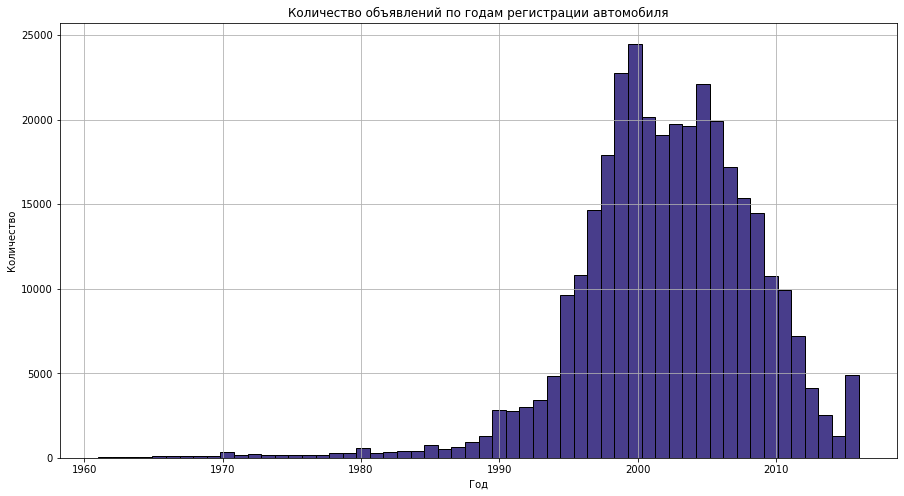

In [30]:
df['registration_year'].hist(bins=df['registration_year'].nunique(), figsize=(15, 8), edgecolor = "black", color='darkslateblue')
plt.title('Количество объявлений по годам регистрации автомобиля')
plt.xlabel('Год')
plt.ylabel('Количество');

Проверим столбец с месяцем регистрации `registration_month`

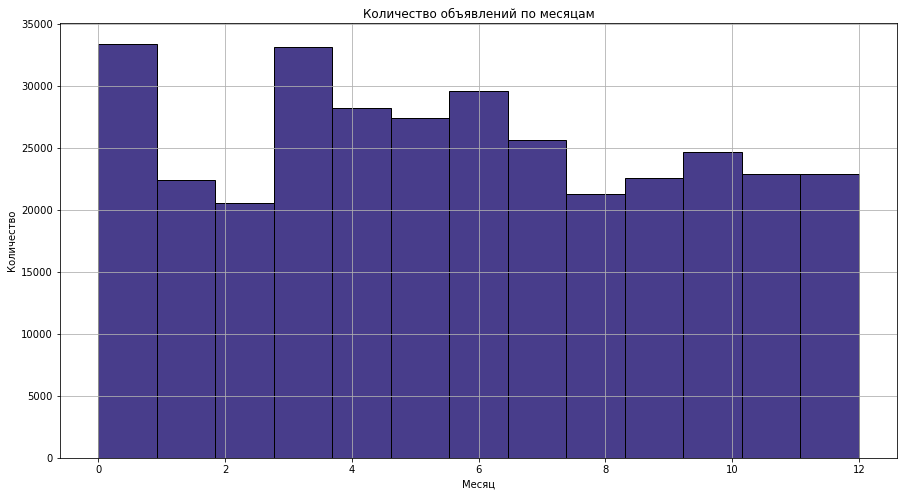

In [31]:
df['registration_month'].hist(bins=df['registration_month'].nunique(), figsize=(15, 8), edgecolor = "black", color='darkslateblue')
plt.title('Количество объявлений по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество');

In [32]:
sales_for_month = df.query('registration_year > 1980').pivot_table(index='registration_month', 
                                                 columns='registration_year', 
                                                 values='model',  
                                                 aggfunc='count').fillna(0)

display(sales_for_month.style.format('{:.0f}').background_gradient('coolwarm'))

registration_year,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
registration_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,41,47,55,43,254,82,102,134,215,930,406,411,562,739,2308,1624,2039,2264,2427,4871,1700,1242,1126,933,2225,814,571,497,396,233,163,106,72,47,196,2753
1,25,14,35,37,48,39,37,58,77,171,216,194,216,277,548,628,960,1023,1452,1717,1421,1215,1321,1260,1247,1313,1131,1135,1007,723,789,592,351,210,141,435
2,13,26,24,22,37,25,29,43,53,123,167,187,168,242,452,567,856,941,1307,1400,1244,1541,1184,1138,1185,1149,968,1065,1106,731,747,573,314,173,139,398
3,32,39,45,42,47,52,37,100,128,214,275,301,398,404,784,924,1314,1692,2349,2255,2079,1864,2421,1756,1963,1925,1734,1439,1404,1058,1083,981,541,314,181,651
4,28,22,36,56,55,45,65,77,123,183,231,282,359,459,684,873,1246,1243,1808,1671,1595,1585,1594,1984,1683,1695,1395,1489,1295,1021,820,753,411,282,108,672
5,25,22,34,43,56,34,51,86,114,165,251,216,250,403,812,853,1107,1235,1677,2063,1801,1581,1647,1573,2082,1666,1474,1268,1308,939,925,689,398,218,92,0
6,25,29,52,21,37,47,67,93,117,164,286,261,276,440,717,1123,1253,1526,1916,1813,1734,1743,1793,1795,2004,2208,1462,1385,1474,1040,928,724,429,207,115,0
7,33,29,38,30,67,53,67,80,108,159,311,246,243,348,623,823,1351,1390,1849,1482,1554,1528,1462,1558,1633,1483,1674,1191,1166,782,772,533,328,158,78,0
8,9,25,19,18,24,28,34,57,66,129,110,176,177,285,494,624,880,1124,1451,1443,1414,1323,1241,1235,1456,1308,1246,1285,1023,724,732,425,281,186,67,0


Нулем в месяцах предположительно, заполняются пропущенные значения. Значительное количество нулевых значений встречается до 2000 года и после 2015. Данные о продажах по месяцам могут показать некоторую сезонность в коллебаниях цен, но учитывая число пропусков скорее всего эта информация будет не доступна. Удалим столбец.

In [33]:
df = df.drop(['registration_month'], axis=1)

Посмотрим распределение цен на автомобили

In [34]:
df.price.describe()

count    334535.000000
mean       4499.710111
std        4554.225482
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

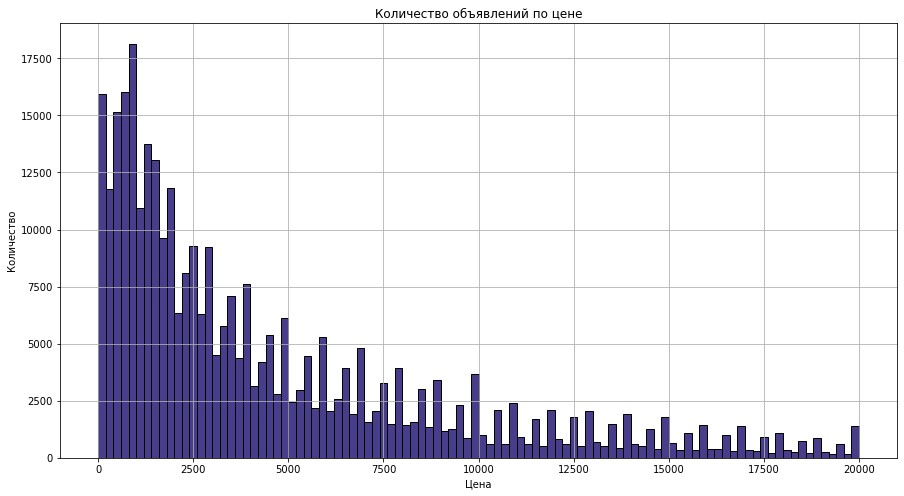

In [35]:
df['price'].hist(bins=100, figsize=(15, 8), edgecolor = "black", color='darkslateblue')
plt.title('Количество объявлений по цене')
plt.xlabel('Цена')
plt.ylabel('Количество');

Видно большое количество значений около 0. Либо таким образом заполнены пропуски когда владелец не указывает цену в объявлении либо автомобили в таком состоянии. Что владелец с радостью избавиться от авто(возможно налог на утилизацию).

Отбросим нулевые значения так как они отрийательно влияют на качество обучения модели

In [36]:
df = df.query('price > 0')

Проверим распределение мощности двигателей

In [37]:
df.power.describe()

count    324884.000000
mean        112.349839
std         183.271676
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

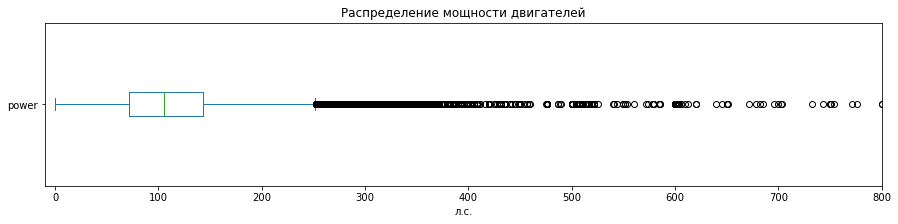

In [38]:
df['power'].plot(kind='box', figsize=(15,3), vert=False, xlim=(-10, 800))
plt.title("Распределение мощности двигателей")
plt.xlabel("л.с.");

Опять значительное число нулевых значений, примем за выбросы все что выше 460 л.с

In [39]:
df = df.query('power < 460')

Проверим столбец с типом транспортного средства

In [40]:
df.vehicle_type.unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Есть значение other, вероятно для более редких типов кузова. Заменим пропуски на unknown

In [41]:
df.vehicle_type = df.vehicle_type.fillna('unknown')

In [42]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,zone
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,NaN,Stuttgart
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,audi unknown_model,125000,gasoline,audi,yes,Frankfurt
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,jeep grand,125000,gasoline,jeep,NaN,Nuernberg_Bayer
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,Nuernberg_Bayer
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,Frankfurt


Проверим встречающиеся типы коробок передач

In [43]:
df.gearbox.unique()

array(['manual', 'auto', nan], dtype=object)

Заполним пропуски

In [44]:
df.gearbox = df.gearbox.fillna('non_spec')

In [45]:
df.fuel_type.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

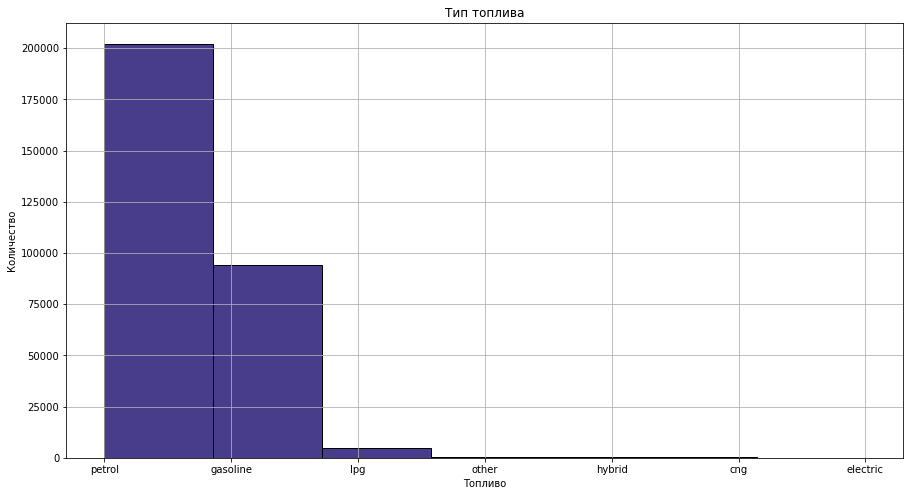

In [46]:
df['fuel_type'].hist(bins=df['fuel_type'].nunique(), figsize=(15, 8), edgecolor = "black", color='darkslateblue')
plt.title('Тип топлива')
plt.xlabel('Топливо')
plt.ylabel('Количество');

Petrol и gasoline слова синонимы для бензина, который преобладает в датасете. Явно не хватает дизельного топлива возможно оно попадает в категорию other.
Пропуски заполним на неизвестный тип топлива

In [47]:
df['fuel_type'].where(~(df['fuel_type'] == 'gasoline'), other='petrol', inplace=True)
df.fuel_type = df.fuel_type.fillna('unkn_fuel')

Перейдем к столбцу `repaired`

In [48]:
df.repaired.unique()

array([nan, 'yes', 'no'], dtype=object)

Заменим пропуски и посмотрим на распределение

In [49]:
df.repaired = df.repaired.fillna('unk_condition')

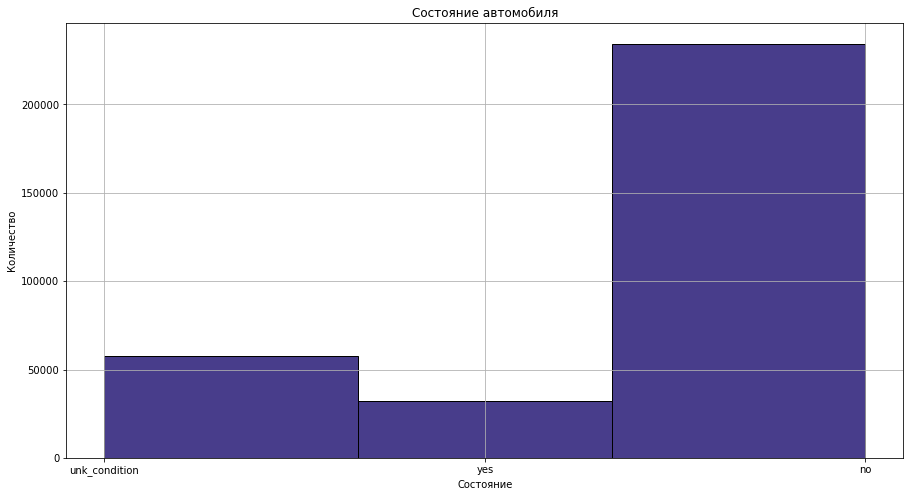

In [50]:
df['repaired'].hist(bins=df['repaired'].nunique(), figsize=(15, 8), edgecolor = "black", color='darkslateblue')
plt.title('Состояние автомобиля')
plt.xlabel('Состояние')
plt.ylabel('Количество');

В основном в выборке представлены в состоянии No, тоесть над ней не проводился серьёзный ремонт. Будем надеяться, что эта колонка также отражает и текущее состояние автомобиля.

Добавим новый признак показывающий насколько заявленный пробег для данного автоотличается от среднего пробега для тойже марки того же года

In [51]:
df['med_model_year_km'] = np.nan
df['med_model_year_km'] = \
(df['med_model_year_km'].fillna(df.groupby(['model', 'registration_year'])['kilometer']\
                            .transform('median')) - df['kilometer']).astype(int) #mean хуже

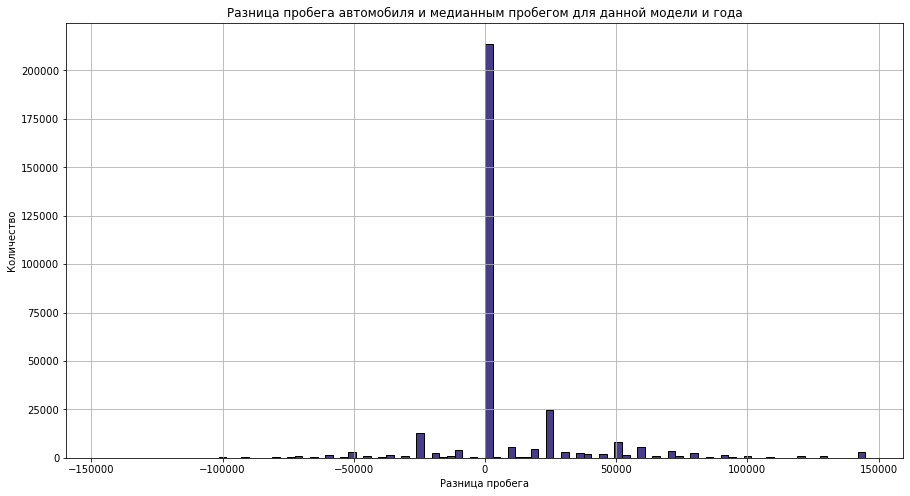

In [52]:
df['med_model_year_km'].hist(bins=100, figsize=(15, 8), edgecolor = "black", color='darkslateblue')
plt.title('Разница пробега автомобиля и медианным пробегом для данной модели и года')
plt.xlabel('Разница пробега')
plt.ylabel('Количество');

Проверим на мультиколлениарность признаков

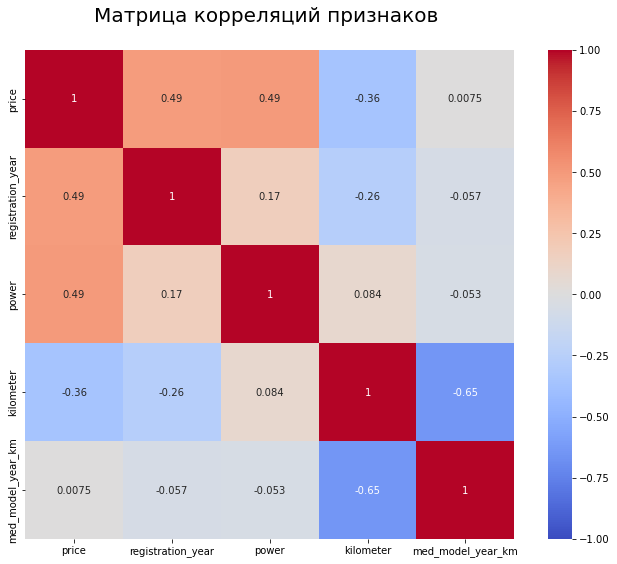

In [53]:
plt.figure(figsize=(12,9))
plt.title('Матрица корреляций признаков \n', fontsize=20)
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', square=True);

Средняя зависимость только между новым признаком и пробегом

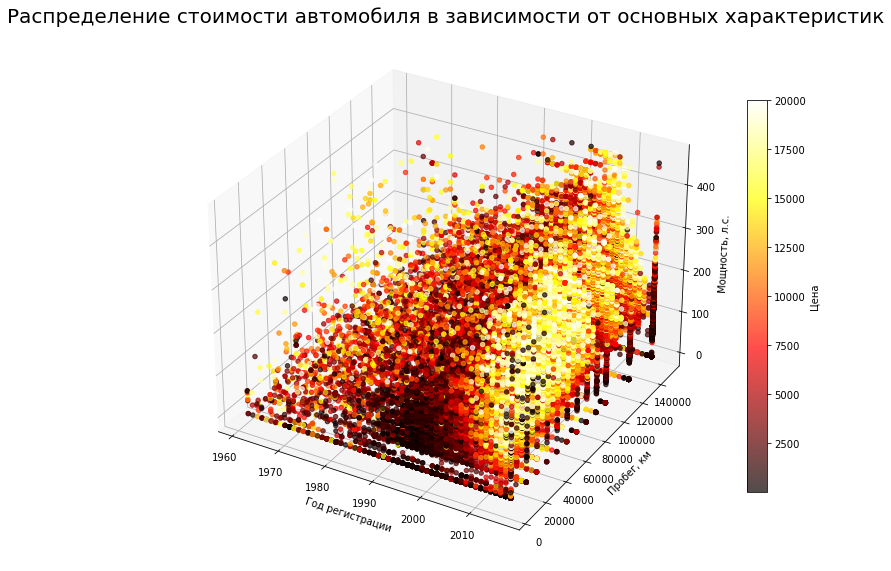

In [54]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

sc = ax.scatter(
    df['registration_year'], 
    df['kilometer'], 
    df['power'], 
    c=df['price'], 
    alpha=0.7, 
    cmap=plt.get_cmap('hot')
    )
    
plt.colorbar(sc, ax=ax, shrink=0.6, label='Цена')
plt.title('Распределение стоимости автомобиля в зависимости от основных характеристик', fontsize=20)
ax.set_xlabel('Год регистрации')
ax.set_ylabel('Пробег, км')
ax.set_zlabel('Мощность, л.с.')
plt.show()

В целом, чем новее и мощнее тем выше цена. Встречаются редкие экземпляры до 1980 по относительно высокой цене

In [55]:
pd.DataFrame({'NaNs, %': round((df.isna().mean()*100),2), 'NaNs, qty': df.isna().sum()}).style.format('{:.2f}').background_gradient('coolwarm')

,"NaNs, %","NaNs, qty"
date_crawled,0.00,0.00
price,0.00,0.00
vehicle_type,0.00,0.00
registration_year,0.00,0.00
gearbox,0.00,0.00
power,0.00,0.00
model,0.00,0.00
kilometer,0.00,0.00
fuel_type,0.00,0.00
brand,0.00,0.00


Все пропуски заполнены

**Вывод**
В данном разделе мы провели ознакомление и обработку данных для обучения модели.

В исходном датасете нам было представлено 354369 объектов с 16 признаками.

`date_crawled`, `date_created`, `last_seen` - даты создания, скачивания, последнего посещения по сути бесполезны для предсказания цены автомобиля, более полезным было бы время подачи и время снятия объявления - по ним косвенно можно предположить адекватность цены

`price` - цена распределена от 0 до 20000, много значений сконцентрировано около 0, возможно либо так заполнились пропуски либо как вариант высокий налог на утилизацию и люди даром отдают машину, еще возможно если продажа идет в формате некого аукциона возможно не поступило ни одного предложения

`registration_year` - год регистрации автомобиля, были удалены выбросы. В основном пик продаж приходится на 2003 год.

`power` - мощность автомобиля, удалены выбросы свыше 450 лс (для серийных автомобилей примем, что большие значения редкость). Много значений около 0. Возможно заполнение пропусков или при состояние авто не позволяет установить истинную мощность

`brand` - представлены основные бренды существующие на рынке. Удалены совпадающие имена. Также обнаружена категория `sonstige_autos` - преположительно являющаяся заменой пропусков, или неизвестных значений(для нее есть одна разновидность модели other)

`model` - обработаны повторы названий одинаковых моделей разных производителей, заполнены пропуски

`kilometer` - по столбцу с пробегом установлено, что большинство автомобилей имеют пробег 150000 км, при учете что пользователь выбирает из доступныхх значений и 150000км максимум, следовательно автомобили имеют пробег выше.

`registration_month` - столбец удален, можно было бы получить сезонные колебания цен, но учитывая пропуски, эта информация была бы утеряна

`postal_code` - было определено что датасет немецкого происхождения и значения индекса были заменены на названия регионов

`repaired` - на большинстве автомобилей не проводилось серьезного ремонта. Не однозначная категория "NotRepaired — была машина в ремонте или нет" предположим, что подразумевается серьезный ремонт(восстановление)

`fuel_type`- объеденены синонимы 'petrol' и 'gasoline', заполнены пропуски, отсутствует категория дизельных авто, вероятно отнсятся к other или к пропускам

`gearbox` - заменены пропуски

`vehicle_type` - заменены пропуски

`number_of_pictures` - признак с 0, удалили

Данные подготовлены переходим к обучению моделей

## Обучение моделей

Подготовим данные для обучения моделей

In [56]:
X, y = df.drop(['price'], axis=1), df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=47,
    shuffle=True)

print('Обучающая выборка:')
print('Доля от общего размера:', round(y_train.shape[0]/df.shape[0], 2))
print('Cтрок, столбцов:', X_train.shape)
print('Доля целевого признака:', round(y_train.mean(), 3))
print('- '*10)


print('Тестовая выборка:')
print('Доля от общего размера:', round(y_test.shape[0]/df.shape[0], 2))
print('Cтрок, столбцов:', X_test.shape)
print('Доля целевого признака:', round(y_test.mean(), 3))
print('-'*30)

Обучающая выборка:
Доля от общего размера: 0.75
Cтрок, столбцов: (243324, 12)
Доля целевого признака: 4631.01
- - - - - - - - - - 
Тестовая выборка:
Доля от общего размера: 0.25
Cтрок, столбцов: (81108, 12)
Доля целевого признака: 4631.344
------------------------------


Разобьем данные на категориальные и числовые обработка для них будет идти по разному

In [57]:
categorical = list(X_train.select_dtypes('object').columns)
print(f"Категориальные признаки: {categorical}")

numerical = list(X_train.select_dtypes('number').columns)
print(f"Числовые признаки: {numerical}")

Категориальные признаки: ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired', 'zone']
Числовые признаки: ['registration_year', 'power', 'kilometer', 'med_model_year_km']


Подготовим pipeline. Две модели на градиентном бустинге одну на основе линейной регрессии

In [58]:
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

num_pipe = Pipeline([
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("regressor", lgbmr())
    ]
)

param_grid = [
    {
        'regressor': [CatBoostRegressor(random_state=47, 
                                        eval_metric='RMSE', 
                                        silent=True, 
                                        early_stopping_rounds=4)],
        'regressor__depth': [6, 8],
        'regressor__learning_rate': [0.25, 0.4],
        'regressor__iterations': [100, 200]
    },
    {
        'regressor': [lgbmr(random_state=47, metric='rmse')],
        'regressor__learning_rate': [0.4, 0.6],
        'regressor__n_estimators': [100, 150],
    },
    {
        'regressor': [Ridge(random_state=47)],
        'regressor__alpha': [ 1, 3, 5],
        'regressor__max_iter': [1000, 5000],
        'regressor__tol': [0.0001, 0.00001]
    }

]

grid = RandomizedSearchCV(pipe, param_grid, n_iter=30 ,cv=3, scoring = 'neg_mean_squared_error', verbose=3)

Обучим модели и замерим время обучения, замер скорости обучения будем осуществлять с помощью команды %%time, в дальнейшем из таблицы с результатами выберем время обучения лучших моделей

In [59]:
%%time
grid.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 24 is smaller than n_iter=30. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/3] END regressor=<catboost.core.CatBoostRegressor object at 0x000002E85A6BC370>, regressor__depth=6, regressor__iterations=100, regressor__learning_rate=0.25;, score=-2946756.554 total time=   2.8s
[CV 2/3] END regressor=<catboost.core.CatBoostRegressor object at 0x000002E85A6BC370>, regressor__depth=6, regressor__iterations=100, regressor__learning_rate=0.25;, score=-3017834.032 total time=   3.1s
[CV 3/3] END regressor=<catboost.core.CatBoostRegressor object at 0x000002E85A6BC370>, regressor__depth=6, regressor__iterations=100, regressor__learning_rate=0.25;, score=-2983597.415 total time=   3.0s
[CV 1/3] END regressor=<catboost.core.CatBoostRegressor object at 0x000002E85A6BC370>, regressor__depth=6, regressor__iterations=100, regressor__learning_rate=0.4;, score=-2833572.915 total time=   3.3s
[CV 2/3] END regressor=<catboost.core.CatBoostRegressor object at 0x000002E85A6BC370>, regressor__depth=6, regressor__iterations=100, regressor__learning_rate=0.4;, score=-2926636.366 t

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['vehicle_type',
                                                                                'gearbox',
                                                                                'model',
                                                                                'fuel_type',
                                                                                'brand',
                                                                                'repaired',
                               

## Анализ моделей

Посмотри на результаты работы моделей по среднеквадратичному значению ошибки

In [60]:
result = pd.DataFrame(grid.cv_results_)
result['mean_test_score'] = (result['mean_test_score']*-1)**0.5

result = result[['param_regressor',
                 'mean_fit_time', 
                 'mean_score_time', 
                 'mean_test_score']].sort_values('mean_test_score').head()
result

,param_regressor,mean_fit_time,mean_score_time,mean_test_score
7,<catboost.core.CatBoostRegressor object at 0x0...,5.235664,0.321483,1617.964038
9,"LGBMRegressor(metric='rmse', random_state=47)",2.776762,0.577868,1627.641130
6,<catboost.core.CatBoostRegressor object at 0x0...,5.017929,0.303827,1632.854986
11,"LGBMRegressor(metric='rmse', random_state=47)",1.055575,0.400711,1641.188784
8,"LGBMRegressor(metric='rmse', random_state=47)",1.215079,0.419995,1644.749746


Примерно одинаковый результат у LGBMRegressor и CatBoostRegressor, но учитывая ожидаемое среднее время получения результата, CatBoostRegressor значительно выигрывает

Теперь отсортируем таблицу результатов по ожидаемому среднему времени предсказания

In [61]:
result = pd.DataFrame(grid.cv_results_)
result['mean_test_score'] = (result['mean_test_score']*-1)**0.5

result[['param_regressor',
        'mean_fit_time', 
        'mean_score_time', 
        'mean_test_score']].sort_values('mean_score_time').head()

,param_regressor,mean_fit_time,mean_score_time,mean_test_score
18,Ridge(random_state=47),0.653142,0.190296,2649.418989
14,Ridge(random_state=47),0.653638,0.190566,2649.417155
12,Ridge(random_state=47),0.634842,0.195253,2649.417155
16,Ridge(random_state=47),0.662571,0.196640,2649.418989
19,Ridge(random_state=47),0.957536,0.197359,2552.394258


Здесь безусловно выигрывает Ridge, но со значительно большим среднеквадратичным отклонением

Для оценки важности признаков модели воспользуемся следующим решением [GitHub](https://github.com/scikit-learn/scikit-learn/issues/12525 "GitHub")  (чтобы вытащить названия признаков из OHE) 

In [62]:
def get_column_names_from_ColumnTransformer(column_transformer, clean_column_names=False, verbose=True):  

    """
    Reference: Kyle Gilde: https://github.com/kylegilde/Kaggle-Notebooks/blob/master/Extracting-and-Plotting-Scikit-Feature-Names-and-Importances/feature_importance.py
    Description: Get the column names from the a ColumnTransformer containing transformers & pipelines
    Parameters
    ----------
    verbose: Bool indicating whether to print summaries. Default set to True.
    Returns
    -------
    a list of the correct feature names
    Note:
    If the ColumnTransformer contains Pipelines and if one of the transformers in the Pipeline is adding completely new columns,
    it must come last in the pipeline. For example, OneHotEncoder, MissingIndicator & SimpleImputer(add_indicator=True) add columns
    to the dataset that didn't exist before, so there should come last in the Pipeline.
    Inspiration: https://github.com/scikit-learn/scikit-learn/issues/12525
    """

    assert isinstance(column_transformer, ColumnTransformer), "Input isn't a ColumnTransformer"
    
    check_is_fitted(column_transformer)

    new_feature_names, transformer_list = [], []

    for i, transformer_item in enumerate(column_transformer.transformers_): 
        transformer_name, transformer, orig_feature_names = transformer_item
        orig_feature_names = list(orig_feature_names)

        if len(orig_feature_names) == 0:
            continue

        if verbose: 
            print(f"\n\n{i}.Transformer/Pipeline: {transformer_name} {transformer.__class__.__name__}\n")
            print(f"\tn_orig_feature_names:{len(orig_feature_names)}")

        if transformer == 'drop':
            continue

        if isinstance(transformer, Pipeline):
            # if pipeline, get the last transformer in the Pipeline
            transformer = transformer.steps[-1][1]

        if hasattr(transformer, 'get_feature_names_out'):
            if 'input_features' in transformer.get_feature_names_out.__code__.co_varnames:
                names = list(transformer.get_feature_names_out(orig_feature_names))
            else:
                names = list(transformer.get_feature_names_out())
        elif hasattr(transformer, 'get_feature_names'):
            if 'input_features' in transformer.get_feature_names.__code__.co_varnames:
                names = list(transformer.get_feature_names(orig_feature_names))
            else:
                names = list(transformer.get_feature_names())

        elif hasattr(transformer,'indicator_') and transformer.add_indicator:
            # is this transformer one of the imputers & did it call the MissingIndicator?

            missing_indicator_indices = transformer.indicator_.features_
            missing_indicators = [orig_feature_names[idx] + '_missing_flag'\
                                  for idx in missing_indicator_indices]
            names = orig_feature_names + missing_indicators

        elif hasattr(transformer,'features_'):
            # is this a MissingIndicator class? 
            missing_indicator_indices = transformer.features_
            missing_indicators = [orig_feature_names[idx] + '_missing_flag'\
                                  for idx in missing_indicator_indices]

        else:

            names = orig_feature_names

        if verbose: 
            print(f"\tn_new_features:{len(names)}")
            print(f"\tnew_features: {names}\n")

        new_feature_names.extend(names)
        transformer_list.extend([transformer_name] * len(names))

    transformer_list, column_transformer_features = transformer_list, new_feature_names

    if clean_column_names:
        new_feature_names = list(clean_columns(pd.DataFrame(columns=new_feature_names)).columns)
    
    return new_feature_names

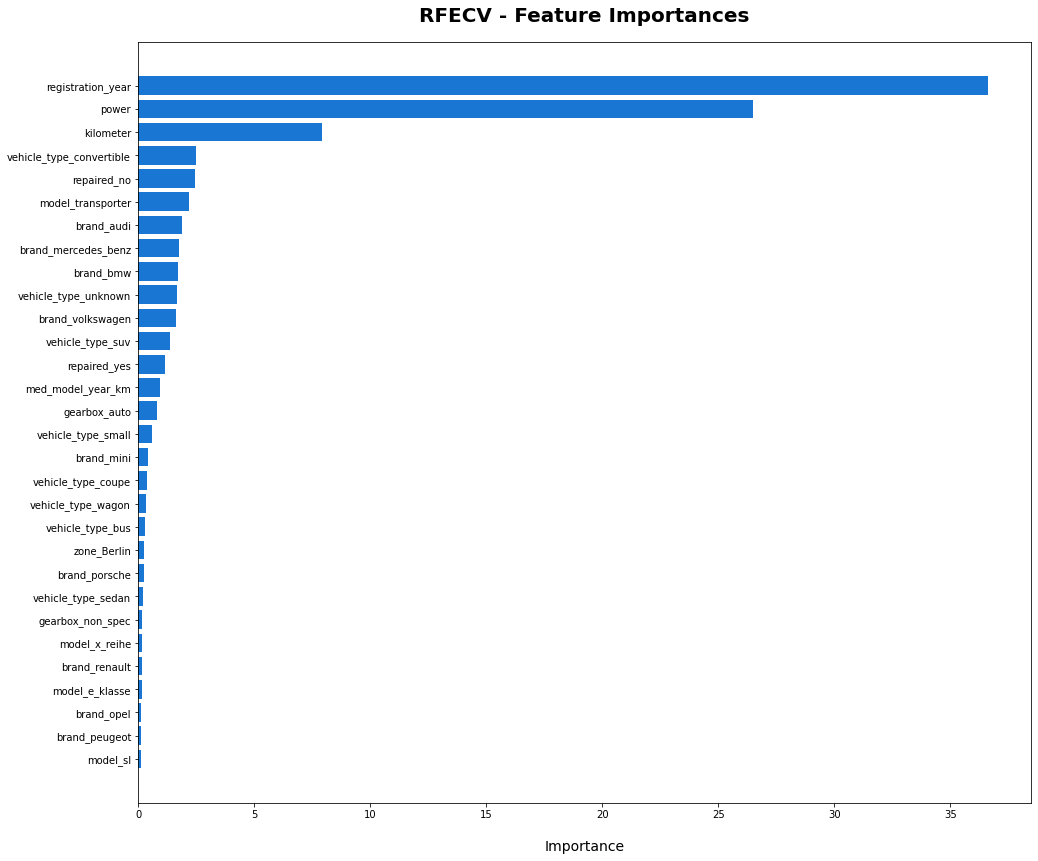

In [63]:
dset = pd.DataFrame()
dset['attr'] = get_column_names_from_ColumnTransformer(grid.best_estimator_.named_steps['preprocessor'], verbose=False)
dset['importance'] = grid.best_estimator_.named_steps["regressor"].feature_importances_

dset = dset.sort_values(by='importance').tail(30)

plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [64]:
print(f"Наиболее важными параметрами влияющими на цену автомобиля по расчетам :\n \
{dset.sort_values(by='importance')['attr'].tail(3)}")

Наиболее важными параметрами влияющими на цену автомобиля по расчетам :
 405            kilometer
404                power
403    registration_year
Name: attr, dtype: object


Проверим работу модели на тестовой выборке

In [65]:
%%time
y_final = grid.best_estimator_.predict(X_test)

Wall time: 408 ms


In [66]:
mean_squared_error(y_test, y_final)**0.5

1607.4531927108726

На тестовой выборке модель показывает результат сопоставимый с результатами при кроссвалидации

In [67]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
y_pred = dummy_regr.predict(X_test)
mean_squared_error(y_test, y_pred)**0.5

4540.46407213384

В сравнении с Dummy моделью также показывает эффективность 

На основании совокупности показанных результатов скорости предсказания и среднеквадратичного отклонения предсказанных результатов рекомендуется выбрать CatBoostRegressor с ниже указанными параметрами

In [68]:
grid.best_estimator_.named_steps["regressor"].get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 200,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'od_wait': 4,
 'random_seed': 47,
 'depth': 8,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learnin

**Вывод**

В данной работе нами предложена модель предсказания цены автомобиля для приложения сервиса по продаже автомобилей с пробегом «Не бит, не крашен».

На этапе обработки данных избавились от столбцов с датой скачивания анкеты, даты последней активности пользователя и даты регистрации как мало информативные. А также столбец с месяцем регистрации авто, так как из-за обилия нулевых значений адекватно заменить не получилось бы. \
Нами были удалены явные дубликаты, а также дубликаты в марках автомобилей, типе топлива.
Для каждой марки при совпадении названии модели создана своя замена.
В столбце с годом выпуска автомобиля и мощностью были удалены выбросы.
Было обнаружено что датасет выбран из автомобилей Германии и на основании этого заменен на область в которой продавался автомобиль.
Выяснили что большая часть автомобилей представлена с пробегом 150000км, и из-за ограничения это значение является максимальным, но наверняка есть автомобили пробег которых значительно больше.
Проверили признаки на мультиколлениарность.
Добавили новый признак с разницей между пробегом автомобиля и медианным пробегом для такой же марки того же года. Что дало небольшой прирост качества.

Для обучения модели нами выбраны две модели на основе градиентного бустинга CatBoostRegressor и LGBMRegressor. И одна попроще Ridge regression.

По скорости обучения и предсказания лидирует Ridge. Обе модели градиентного бустинга проигрывают в скорости зато выигрывают в качестве предсказания. 

По совокупности результатов качества  и скорости предсказания, рекомендуется для разработки приложения использовать модель на основе CatBoostRegressor с рассчитанными выше параметрами.